STEP 2: LOADING DATASET
✓ Data Loaded Successfully.
✓ Dataset shape: (648, 20)
✓ Columns: ['customer_id', 'age', 'occupation_status', 'years_employed', 'annual_income', 'credit_score', 'credit_history_years', 'savings_assets', 'current_debt', 'defaults_on_file', 'delinquencies_last_2yrs', 'derogatory_marks', 'product_type', 'loan_intent', 'loan_amount', 'interest_rate', 'debt_to_income_ratio', 'loan_to_income_ratio', 'payment_to_income_ratio', 'loan_status']

STEP 3: ADVANCED PREPROCESSING

[3.1] Handling Missing Data...
✓ Missing data handled

[3.2] Converting Categorical Variables to Numeric...
 ✓ Encoded: occupation_status
 ✓ Encoded: product_type
 ✓ Encoded: loan_intent

[3.3] Converting Numeric Data to Categorical (Binning)...
✓ Created 7 categorical features

[3.4] Creating Engineered Features...
✓ Created engineered features successfully

STEP 4: SELECTING FEATURES
✓ Total features selected: 24
✓ Dataset shape: (648, 24)

STEP 5: SPLITTING DATASET
✓ Training samples: 518
✓ Testi

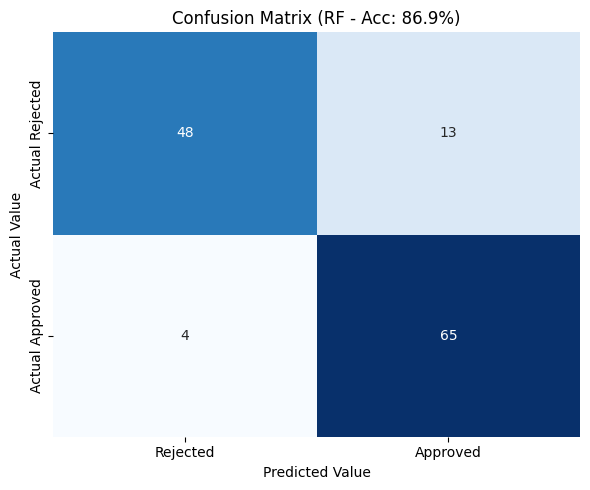


STEP 10: NEW APPLICANT PREDICTION

RESULT:
✅ LOAN APPROVED (Confidence: 94.76%)


In [20]:
# ==========================================
# OPTIMIZED LOAN APPROVAL CLASSIFICATION
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# ==========================================
# STEP 2: LOADING DATASET
# ==========================================
print("="*70)
print("STEP 2: LOADING DATASET")
print("="*70)

dataset = pd.read_csv("Loan_approval_data_2025.csv")
dataset.columns = dataset.columns.str.strip()

print("✓ Data Loaded Successfully.")
print(f"✓ Dataset shape: {dataset.shape}")
print(f"✓ Columns: {list(dataset.columns)}")

# ==========================================
# STEP 3: ADVANCED PREPROCESSING
# ==========================================
print("\n" + "="*70)
print("STEP 3: ADVANCED PREPROCESSING")
print("="*70)

print("\n[3.1] Handling Missing Data...")
print("✓ Missing data handled")

num_cols = dataset.select_dtypes(include=['int64','float64']).columns
cat_cols = dataset.select_dtypes(include=['object']).columns

dataset[num_cols] = SimpleImputer(strategy='mean').fit_transform(dataset[num_cols])
for col in cat_cols:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

print("\n[3.2] Converting Categorical Variables to Numeric...")
label_encoders = {}
for col in cat_cols:
    if col != 'customer_id':
        le = LabelEncoder()
        dataset[col] = le.fit_transform(dataset[col])
        label_encoders[col] = le
        print(f" ✓ Encoded: {col}")

# Fix integer columns
int_cols = [
    'defaults_on_file',
    'delinquencies_last_2yrs',
    'derogatory_marks',
    'years_employed',
    'credit_history_years'
]
dataset[int_cols] = dataset[int_cols].round().astype(int)

# ==========================================
# STEP 3.3 BINNING
# ==========================================
print("\n[3.3] Converting Numeric Data to Categorical (Binning)...")

dataset['age_category'] = pd.cut(dataset['age'], [0,25,35,45,55,100], labels=[0,1,2,3,4])
dataset['credit_score_category'] = pd.cut(dataset['credit_score'], [0,580,670,740,800,850], labels=[0,1,2,3,4])
dataset['income_category'] = pd.qcut(dataset['annual_income'], 5, labels=[0,1,2,3,4])
dataset['debt_category'] = pd.qcut(dataset['current_debt'], 4, labels=[0,1,2,3])
dataset['interest_rate_category'] = pd.cut(dataset['interest_rate'], [0,8,12,16,100], labels=[0,1,2,3])
dataset['loan_amount_category'] = pd.qcut(dataset['loan_amount'], 4, labels=[0,1,2,3])
dataset['dti_category'] = pd.cut(dataset['debt_to_income_ratio'], [0,0.2,0.35,0.5,100], labels=[0,1,2,3])

print("✓ Created 7 categorical features")

# ==========================================
# STEP 3.4 FEATURE ENGINEERING
# ==========================================
print("\n[3.4] Creating Engineered Features...")

dataset['credit_efficiency'] = dataset['credit_score'] / (dataset['interest_rate'] + 0.1)
dataset['total_negatives'] = dataset['defaults_on_file'] + dataset['delinquencies_last_2yrs'] + dataset['derogatory_marks']
dataset['penalized_score'] = dataset['credit_score'] - dataset['defaults_on_file']*150 - dataset['delinquencies_last_2yrs']*50 - dataset['derogatory_marks']*30
dataset['income_debt_ratio'] = dataset['annual_income'] / (dataset['current_debt'] + 1)
dataset['savings_loan_ratio'] = dataset['savings_assets'] / (dataset['loan_amount'] + 1)

print("✓ Created engineered features successfully")

# ==========================================
# STEP 4: FEATURE SELECTION
# ==========================================
print("\n" + "="*70)
print("STEP 4: SELECTING FEATURES")
print("="*70)

user_features = ['credit_score','interest_rate','defaults_on_file','delinquencies_last_2yrs']

additional_features = [
    'age_category','credit_score_category','income_category',
    'debt_category','interest_rate_category','loan_amount_category',
    'dti_category','credit_efficiency','total_negatives',
    'penalized_score','income_debt_ratio','savings_loan_ratio',
    'annual_income','loan_amount','debt_to_income_ratio',
    'credit_history_years','derogatory_marks','years_employed',
    'savings_assets','current_debt'
]

all_features = list(dict.fromkeys(user_features + additional_features))

X = dataset[all_features].fillna(dataset[all_features].mode().iloc[0])
y = dataset['loan_status']

print(f"✓ Total features selected: {len(all_features)}")
print(f"✓ Dataset shape: {X.shape}")

# ==========================================
# STEP 5: SPLITTING DATASET
# ==========================================
print("\n" + "="*70)
print("STEP 5: SPLITTING DATASET")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")

# ==========================================
# STEP 6: FEATURE SCALING
# ==========================================
print("\n" + "="*70)
print("STEP 6: FEATURE SCALING")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ StandardScaler applied successfully")

# ==========================================
# STEP 7: TRAIN MODEL
# ==========================================
print("\n" + "="*70)
print("STEP 7: TRAINING RANDOM FOREST MODEL")
print("="*70)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully!")
# ==========================================
# STEP 8: PREDICTION TABLE (10 ROWS)
# ==========================================
print("\n" + "-"*40)
print(" PREDICTION SAMPLE (First 10 Rows)")
print("-"*40)

# Reset index for clean looping
y_test_reset = y_test.reset_index(drop=True)

# Create a DataFrame for the display
results_df = pd.DataFrame({
    'Actual': y_test_reset[:10],
    'Predicted': y_pred[:10]
})
results_df['Result'] = np.where(results_df['Actual'] == results_df['Predicted'], '✅ Match', '❌ Fail')

print(results_df)
print("\n(0 = Rejected, 1 = Approved)")
# ==========================================
# STEP 8: MODEL EVALUATION
# ==========================================
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION")
print("="*70)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*40)
print(f" MODEL ACCURACY: {accuracy*100:.2f}%")
print("="*40)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Actual Rejected', 'Actual Approved'])
plt.title(f'Confusion Matrix (RF - Acc: {accuracy*100:.1f}%)')
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.tight_layout()
plt.show()
# ==========================================
# STEP 10: USER INPUT & PREDICTION
# ==========================================
print("\n" + "="*70)
print("STEP 10: NEW APPLICANT PREDICTION")
print("="*70)

approved_mean = dataset[dataset['loan_status']==1].mean(numeric_only=True)
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

input_data = {}
for feat in user_features:
    min_v, max_v = dataset[feat].min(), dataset[feat].max()

    if set(dataset[feat].unique()).issubset({0,1}):
        val = int(input(f"{feat} (0 or 1): "))
    elif pd.api.types.is_integer_dtype(dataset[feat]):
        val = int(input(f"{feat} INTEGER [{int(min_v)} - {int(max_v)}]: "))
    else:
        val = float(input(f"{feat} DECIMAL [{min_v:.2f} - {max_v:.2f}]: "))

    input_data[feat] = val

input_df = pd.DataFrame([input_data])

for feat in all_features:
    if feat not in input_df.columns:
        input_df[feat] = approved_mean[feat] if feat in numeric_features else dataset[feat].mode()[0]

input_scaled = scaler.transform(input_df)
pred = model.predict(input_scaled)
proba = model.predict_proba(input_scaled)[0]

print("\nRESULT:")
if pred[0]==1:
    print(f"✅ LOAN APPROVED (Confidence: {proba[1]*100:.2f}%)")
else:
    print(f"❌ LOAN REJECTED (Confidence: {proba[0]*100:.2f}%)")


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.impute import SimpleImputer

In [2]:
# ==========================================
# STEP 2: LOADING DATASET
# ==========================================
print("="*70)
print("STEP 2: LOADING DATASET")
print("="*70)

dataset = pd.read_csv("Loan_approval_data_2025.csv")
dataset.columns = dataset.columns.str.strip()

print("✓ Data Loaded Successfully.")
print(f"✓ Dataset shape: {dataset.shape}")
print(f"✓ Columns: {list(dataset.columns)}")

STEP 2: LOADING DATASET
✓ Data Loaded Successfully.
✓ Dataset shape: (648, 20)
✓ Columns: ['customer_id', 'age', 'occupation_status', 'years_employed', 'annual_income', 'credit_score', 'credit_history_years', 'savings_assets', 'current_debt', 'defaults_on_file', 'delinquencies_last_2yrs', 'derogatory_marks', 'product_type', 'loan_intent', 'loan_amount', 'interest_rate', 'debt_to_income_ratio', 'loan_to_income_ratio', 'payment_to_income_ratio', 'loan_status']


In [3]:
# ==========================================
# STEP 3: ADVANCED PREPROCESSING
# ==========================================
print("\n" + "="*70)
print("STEP 3: ADVANCED PREPROCESSING")
print("="*70)

print("\n[3.1] Handling Missing Data...")
print("✓ Missing data handled")

num_cols = dataset.select_dtypes(include=['int64','float64']).columns
cat_cols = dataset.select_dtypes(include=['object']).columns

dataset[num_cols] = SimpleImputer(strategy='mean').fit_transform(dataset[num_cols])
for col in cat_cols:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

print("\n[3.2] Converting Categorical Variables to Numeric...")
label_encoders = {}
for col in cat_cols:
    if col != 'customer_id':
        le = LabelEncoder()
        dataset[col] = le.fit_transform(dataset[col])
        label_encoders[col] = le
        print(f" ✓ Encoded: {col}")

# Fix integer columns
int_cols = [
    'defaults_on_file',
    'delinquencies_last_2yrs',
    'derogatory_marks',
    'years_employed',
    'credit_history_years'
]
dataset[int_cols] = dataset[int_cols].round().astype(int)



STEP 3: ADVANCED PREPROCESSING

[3.1] Handling Missing Data...
✓ Missing data handled

[3.2] Converting Categorical Variables to Numeric...
 ✓ Encoded: occupation_status
 ✓ Encoded: product_type
 ✓ Encoded: loan_intent


/var/folders/cx/80xfxwwj6lbdhqx9gz3994d80000gn/T/ipykernel_808/4261092978.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mode()[0], inplace=True)


In [4]:
# ==========================================
# STEP 3.3 BINNING
# ==========================================
print("\n[3.3] Converting Numeric Data to Categorical (Binning)...")

dataset['age_category'] = pd.cut(dataset['age'], [0,25,35,45,55,100], labels=[0,1,2,3,4])
dataset['credit_score_category'] = pd.cut(dataset['credit_score'], [0,580,670,740,800,850], labels=[0,1,2,3,4])
dataset['income_category'] = pd.qcut(dataset['annual_income'], 5, labels=[0,1,2,3,4])
dataset['debt_category'] = pd.qcut(dataset['current_debt'], 4, labels=[0,1,2,3])
dataset['interest_rate_category'] = pd.cut(dataset['interest_rate'], [0,8,12,16,100], labels=[0,1,2,3])
dataset['loan_amount_category'] = pd.qcut(dataset['loan_amount'], 4, labels=[0,1,2,3])
dataset['dti_category'] = pd.cut(dataset['debt_to_income_ratio'], [0,0.2,0.35,0.5,100], labels=[0,1,2,3])

print("✓ Created 7 categorical features")


[3.3] Converting Numeric Data to Categorical (Binning)...
✓ Created 7 categorical features


In [6]:
# ==========================================
# STEP 3.4 FEATURE ENGINEERING
# ==========================================
print("\n[3.4] Creating Engineered Features...")

dataset['credit_efficiency'] = dataset['credit_score'] / (dataset['interest_rate'] + 0.1)
dataset['total_negatives'] = dataset['defaults_on_file'] + dataset['delinquencies_last_2yrs'] + dataset['derogatory_marks']
dataset['penalized_score'] = dataset['credit_score'] - dataset['defaults_on_file']*150 - dataset['delinquencies_last_2yrs']*50 - dataset['derogatory_marks']*30
dataset['income_debt_ratio'] = dataset['annual_income'] / (dataset['current_debt'] + 1)
dataset['savings_loan_ratio'] = dataset['savings_assets'] / (dataset['loan_amount'] + 1)

print("✓ Created engineered features successfully")


[3.4] Creating Engineered Features...
✓ Created engineered features successfully


In [7]:
# ==========================================
# STEP 4: FEATURE SELECTION
# ==========================================
print("\n" + "="*70)
print("STEP 4: SELECTING FEATURES")
print("="*70)

user_features = ['credit_score','interest_rate','defaults_on_file','delinquencies_last_2yrs']

additional_features = [
    'age_category','credit_score_category','income_category',
    'debt_category','interest_rate_category','loan_amount_category',
    'dti_category','credit_efficiency','total_negatives',
    'penalized_score','income_debt_ratio','savings_loan_ratio',
    'annual_income','loan_amount','debt_to_income_ratio',
    'credit_history_years','derogatory_marks','years_employed',
    'savings_assets','current_debt'
]

all_features = list(dict.fromkeys(user_features + additional_features))

X = dataset[all_features].fillna(dataset[all_features].mode().iloc[0])
y = dataset['loan_status']

print(f"✓ Total features selected: {len(all_features)}")
print(f"✓ Dataset shape: {X.shape}")



STEP 4: SELECTING FEATURES
✓ Total features selected: 24
✓ Dataset shape: (648, 24)


In [8]:
# ==========================================
# STEP 5: SPLITTING DATASET
# ==========================================
print("\n" + "="*70)
print("STEP 5: SPLITTING DATASET")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")



STEP 5: SPLITTING DATASET
✓ Training samples: 518
✓ Testing samples: 130


In [9]:
# ==========================================
# STEP 6: FEATURE SCALING
# ==========================================
print("\n" + "="*70)
print("STEP 6: FEATURE SCALING")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ StandardScaler applied successfully")


STEP 6: FEATURE SCALING
✓ StandardScaler applied successfully


In [10]:
# ==========================================
# STEP 7: TRAIN MODEL
# ==========================================
print("\n" + "="*70)
print("STEP 7: TRAINING RANDOM FOREST MODEL")
print("="*70)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully!")


STEP 7: TRAINING RANDOM FOREST MODEL
✓ Model trained successfully!


In [12]:
# ==========================================
# STEP 8: PREDICTION TABLE (10 ROWS)
# ==========================================
print("\n" + "-"*40)
print(" PREDICTION SAMPLE (First 10 Rows)")
print("-"*40)

y_pred = model.predict(X_test_scaled)

# Reset index for clean looping
y_test_reset = y_test.reset_index(drop=True)

# Create a DataFrame for the display
results_df = pd.DataFrame({
    'Actual': y_test_reset[:10],
    'Predicted': y_pred[:10]
})
results_df['Result'] = np.where(results_df['Actual'] == results_df['Predicted'], '✅ Match', '❌ Fail')

print(results_df)
print("\n(0 = Rejected, 1 = Approved)")


----------------------------------------
 PREDICTION SAMPLE (First 10 Rows)
----------------------------------------
   Actual  Predicted   Result
0     0.0        1.0   ❌ Fail
1     1.0        1.0  ✅ Match
2     0.0        0.0  ✅ Match
3     0.0        0.0  ✅ Match
4     1.0        1.0  ✅ Match
5     1.0        1.0  ✅ Match
6     1.0        1.0  ✅ Match
7     0.0        1.0   ❌ Fail
8     0.0        0.0  ✅ Match
9     1.0        1.0  ✅ Match

(0 = Rejected, 1 = Approved)


In [ ]:
# ==========================================
# STEP 8: MODEL EVALUATION
# ==========================================
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION")
print("="*70)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*40)
print(f" MODEL ACCURACY: {accuracy*100:.2f}%")
print("="*40)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Actual Rejected', 'Actual Approved'])
plt.title(f'Confusion Matrix (RF - Acc: {accuracy*100:.1f}%)')
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# STEP 10: USER INPUT & PREDICTION
# ==========================================
print("\n" + "="*70)
print("STEP 10: NEW APPLICANT PREDICTION")
print("="*70)

approved_mean = dataset[dataset['loan_status']==1].mean(numeric_only=True)
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

input_data = {}
for feat in user_features:
    min_v, max_v = dataset[feat].min(), dataset[feat].max()

    if set(dataset[feat].unique()).issubset({0,1}):
        val = int(input(f"{feat} (0 or 1): "))
    elif pd.api.types.is_integer_dtype(dataset[feat]):
        val = int(input(f"{feat} INTEGER [{int(min_v)} - {int(max_v)}]: "))
    else:
        val = float(input(f"{feat} DECIMAL [{min_v:.2f} - {max_v:.2f}]: "))

    input_data[feat] = val

input_df = pd.DataFrame([input_data])

for feat in all_features:
    if feat not in input_df.columns:
        input_df[feat] = approved_mean[feat] if feat in numeric_features else dataset[feat].mode()[0]

input_scaled = scaler.transform(input_df)
pred = model.predict(input_scaled)
proba = model.predict_proba(input_scaled)[0]

print("\nRESULT:")
if pred[0]==1:
    print(f"✅ LOAN APPROVED (Confidence: {proba[1]*100:.2f}%)")
else:
    print(f"❌ LOAN REJECTED (Confidence: {proba[0]*100:.2f}%)")
